In [1]:
# %env CUDA_VISIBLE_DEVICES=0,2,3
# %env LIBRARY_PATH=/usr/local/cuda/lib64
import sys
import os
sys.path.append(os.path.expanduser("~/.local/lib/python3.6/site-packages/"))

# Практическое задание

## Вычитание фона

### О задании

В данном задании вам предлагается самостоятельно реализовать алгоритм вычитания фона ViBe. Протестировать этот алгорит на датасете ChangeDetection 2014 года, а также сравнить качество его работы с алгоритмом, основанным на смеси гауссиан. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. Необходимо установить следующие пакеты: `numpy`, `skimage`, `opencv`. 

In [2]:
# !pip install numpy scikit-image opencv-python

##  Часть 1

В этой части задания вам предстоит реализовать алгоритм вычитания фона *ViBe* и протестировать его качество работы на датасете *Change Detection 2014*.


**1. (3 балла)**

Прочитайте статью, выданную вам совместно с ноутбуком, описывающую алгоритм *ViBe* и реализуйте следующие его ключевые особенности: 
1. *Цветовая модель пикселей.* Для каждого пикселя хранится набор $\{p_1, ..., p_N\}$ - значений цвета данного пикселя в предыдущие моменты времени. 
2. *Классификация пикселей.* Для каждого нового кадра пиксель считается пикселем фона, если среди значений  $\{p_1, ..., p_N\}$ его цветовой модели содержится не менее K значений, расстояние до которых меньше радиуса R по евклидовой метрике.
3. *Обновления цветовой модели.* Если пиксель был классифицирован как пиксель фона, его цветовая модель обновляется следущий образом: случайно выбранная точка цветовой модели данного пикселя заменяется на новое значения. 
4. *Модель инициализации.* Иницилизируйте цветовую модель для каждого пикселя значением цвета пикселя на первом кадре, а также значениями цвета случайно выбранных соседей(используйте 4'x или 8'ми-связную модель соседства);

Дополните реализуйте следущую модификацию, предложенную этими же авторами позднее:
* "Random time subsampling". Во многих практических ситуациях нет необходимости обновлять фоновую модель каждого пикселя для каждого нового кадра. Если сделать фоновое обновление менее частым, мы искусственно продлеваем средний срок службы фоновых образцов и таким образом боремся со случайными движениями возникающими в кадре. "Random time subsampling" заключается в том что бы не обновлять фоновую модель для каждого пикселя после каждого кадра. А для каждому пикселю сопоставить случаюную величину, которая будет отвечать за то, чтобы обновлять модель данного пикселя или нет, так чтобы обновление произодило в среднем раз в `subsampling_time` кадров (т.е обновлять фоновую модель каждого пикселя с вероятностью `1 / subsampling_time`).

*Замечание*:

Для реализации модели Vibe используйте предоставленный шаблон. Реализация алгоритма на питоне будет работать медленно, поэтому старайтесь выполнять как можно больше вычислений матрично.

In [3]:
import os
from IPython import display

import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
from tqdm import tqdm

In [4]:
from copy import deepcopy

In [5]:
class Vibe:
    def __init__(self, sample_amount, radius, K, subsampling_time):
        """
        'Visual Background Extractor' algorithm of background subtraction

        :param sample_amount: number of samples per pixel
        :param radius: radius of the sphere
        :param K: number of close samples for being part of background
        :param subsampling_time: amount of random subsampling
        """

        self.sample_amount = sample_amount
        self.radius = radius
        self.K = K
        self.subsampling_time = subsampling_time
        self.samples = None
        self.initialized = False
        self.mask = None

    def initialize(self, image):
        """
        Initialize the model with frame of video sequence.

        :param image: initializining frame
        """
        
        # for now just in loop
        self.samples = np.zeros((self.sample_amount, image.shape[0], image.shape[1], image.shape[2]))

        for index in range(self.sample_amount):
            for height in range(image.shape[0]):
                for width in range(image.shape[1]):
                    mode = np.random.randint(0, 5)
                    neighbour_pixels = (image[height, width, :],
                                        image[max(height - 1, 0), width,:],
                                        image[min(height, image.shape[0]), width,:],
                                        image[height, max(width - 1, 0),:],
                                        image[height, min(width, image.shape[1]), :])                                        
                    self.samples[index, height, width , :] = neighbour_pixels[mode]

        self.initialized = True

    def apply(self, image):
        """
        Apply background subtraction algorithm to the next image,
        update internal parameters and return foreground mask.
        If model is not yet initialized, model must be initialized with this image.

        :param image: next image in video sequence
        :return: foreground mask
        """

        if not self.initialized:
            self.initialize(image)
                    
        ## Vectorized
        distances = np.sqrt(np.square(self.samples - image).sum(axis=-1))

        mask = (distances < self.radius).sum(axis=0) > self.K

        update_ind = np.where(np.logical_and(np.random.binomial(1, p=1 / self.subsampling_time, size=image.shape[:2]),
                                             mask))
        
        maps_to_change = np.random.randint(0, self.sample_amount, size=image.shape[:2])[update_ind]
        self.samples[maps_to_change, update_ind[0], update_ind[1]] = image[update_ind]
        
        # Random spatial neigbour distortion
        row_neighbour = update_ind[0] + np.random.randint(-1, 2, size=update_ind[0].shape)
        col_neighbour = update_ind[1] + np.random.randint(-1, 2, size=update_ind[1].shape)
        row_neighbour = np.clip(row_neighbour, 0, image.shape[0] - 1)
        col_neighbour = np.clip(col_neighbour, 0, image.shape[1] - 1)
        
        self.samples[maps_to_change, row_neighbour, col_neighbour] = image[update_ind]
        
#         # EXPERIMENT change foregraound from time to time(kill signal:( )
#         update_ind = np.where(np.logical_and(np.random.binomial(1, p=1 / self.subsampling_time**2, size=image.shape[:2]),
#                                      1 - mask))
        
#         maps_to_change = np.random.randint(0, self.sample_amount, size=image.shape[:2])[update_ind]
#         self.samples[maps_to_change, update_ind[0], update_ind[1]] = image[update_ind]
                
        return 1 - mask

**2. (1 балл)**

Посмотрите как работает алгоритм на различных фрагментах видео из категориии Baseline датасета ChangeDetection2014, выданного вам совместно с ноутбуком. Поиграйтесь с параметрами и сделайте выводы.

Для визуализации покадрового применения алгоритма можете использовать код, написанный ниже.

*Замечание: *  
Полную версию датасета можно найти [здесь](http://changedetection.net/)

In [6]:
def image_generator(dirpath, first_frame=1, last_frame=None):
    """
    Generator of (frame_number, image, groundtruth) tuples.

    :param dirpath: Path to dir contained 'input' and 'groundtruth' subdirs
    :param first_frame: int, optional. Frame number from which the generator starts (inclusive)
    :param last_frame: int, optional. If provide, frame number  where the generator stops (inclusive)
    :return: (frame_number, image, groundtruth) tuples
    """

    input_format_name = 'input/in{:06d}.jpg'
    gt_format_name = 'groundtruth/gt{:06d}.png'

    numb = first_frame
    while (last_frame is None) or numb <= last_frame:
        input_path = os.path.join(dirpath, input_format_name.format(numb))
        gt_path = os.path.join(dirpath, gt_format_name.format(numb))

        if os.path.exists(input_path):
            input_image = skimage.io.imread(input_path)
            gt_image = skimage.io.imread(gt_path)
            if len(input_image.shape) == 2:
                input_image = input_image[..., np.newaxis]
            yield numb, input_image, gt_image
        else:
            break
        numb += 1
        
        
def apply_bg_substractor(bg_substractor, image_generator):
    """
    Apply background substruction algorithm for each frame of image_generator consistently

    :return: generator of (frame_number, frame, bg_substructor_mask, groundtruth) tuples
    """

    for numb, frame, gt in image_generator:
        mask = bg_substractor.apply(frame)
        yield numb, frame, mask, gt


def plot_bg_result(frame_number, frame, mask, gt, axs=None):
    """
    Draw frame, foreground mask, groundtruth mask images on axes.
    """
    if axs is None:
        _, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(frame)
    axs[0].set_title("Frame: {}".format(frame_number))

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("BG result")

    axs[2].imshow(gt, cmap='gray')
    axs[2].set_title("Ground truth")

In [9]:
DIR_PATH = os.path.expanduser("~/data/Images_2_data/HW_4_data/dataset/baseline/office")

In [61]:
image_gen = image_generator(DIR_PATH, first_frame=570, last_frame=630)
bg_substractor = Vibe(sample_amount=30, radius=30, K=2, subsampling_time=5)

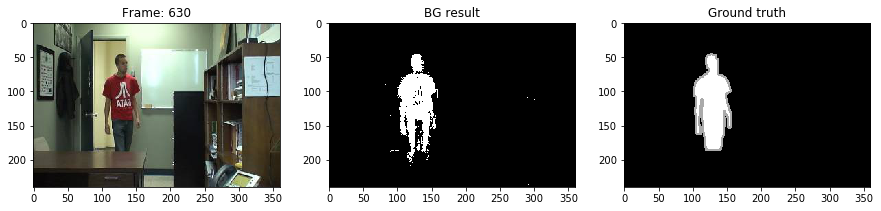

61it [00:56,  1.61it/s]


In [62]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

Итак, разберем влияение параметров по порядку:
- sample_amount говорит о том, соклько информации мы храним о каждом пикселе. При очень малом значение(например 1) мы храним непонятно что, так как одно число не говорит ничего ни о соседях пикселя, ни о распределении цветов. То есть, в идеале, чем больше sample_amount, тем лучше. По достижении какого-то порога я не перестал замечать разницу от варьирования этого параметра.
- Понятно, что параметры radius и K, по сути похожи, потому что варьируя радиус мы можем регулировать число объектов попадающих в данный радиус. В моем случае вариция этих парметров не сильно влияла на результат, если конечно не делать их экстремально большими/маленькими. При критических значениях, маска становилась либо сильно доминирована фоном/сигналом.
- subsampling_time влияет тем, что при очень частом обновлении(малом subsampling_time) человек, объект который стоит неподвижно, как в случае office, начинает становиться фоном, и со временем пропадает. При очень редком обновлении, объек может просто не успевать следить на настоящим объектом.

Все фото для различных ситуаций и значений параметров внизу, в пункте 3.

**3. (1 балл)**

Визуально протестируйте алгоритм на видео из категории Baseline.  Покажите ключевые кадры и проанализируйте результаты.  Сделайте выводы о плюсах и минусах алгоритма. 

In [35]:
from PIL import Image

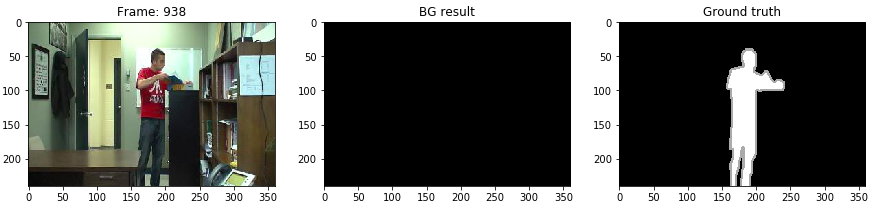

In [38]:
# Small sample_amount
Image.open("1.png")

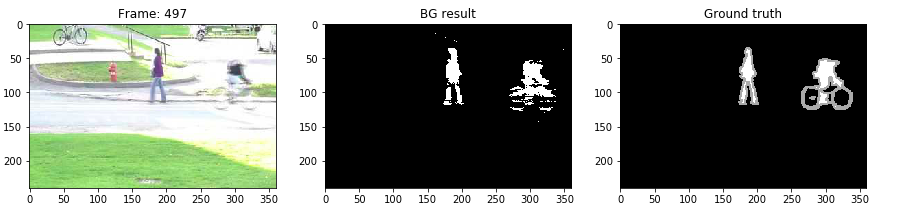

In [39]:
# Good parameters
Image.open("2.png")

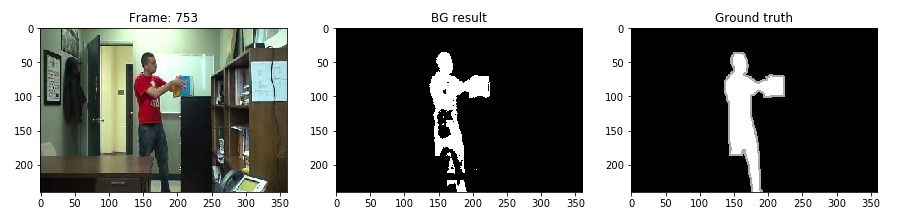

In [40]:
# Small subsampling_time
Image.open("3.png")

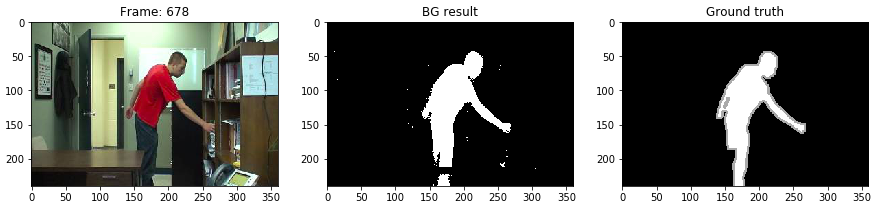

In [41]:
# Good parameters
Image.open("4.png")

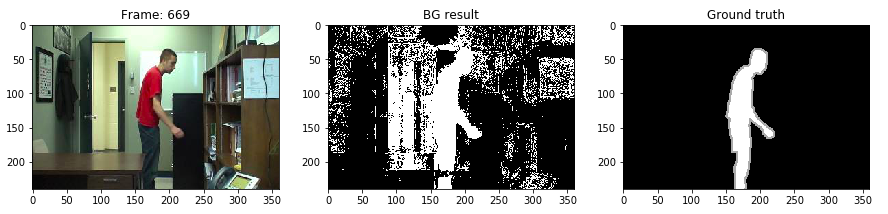

In [42]:
# Very small radius
Image.open("5.png")

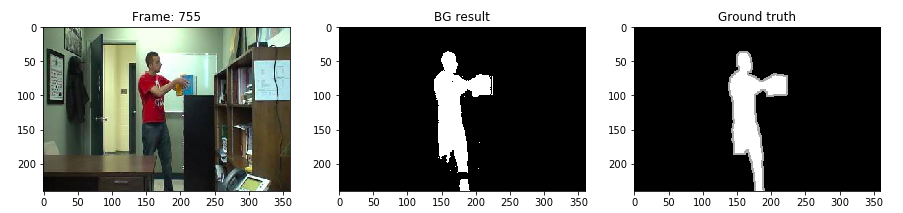

In [43]:
# Good parameters
Image.open("6.png")

**Выводы:**
...

В целом, при верно подобранных параметрах алгоритм работает хорошо. Какие есть минусы? Например, на фото выше, у человека пропала часть ноги, так как она слилась по фону с плинтусом комнаты на заднем плане. Это думаю, фундаментальный недостаток алгоритма, как как он ищет ближайших соседей и если они близки по цвету - ничего не поделаешь. Еще один недостаток, что в исходной версии, если вдруг пиксель был ошибочно приписан к объекту, мы не будем его обновлять, и можем получить "призраков" застывших в кадре. Это отчетливо видно, если начинать не с пустого кадра, с кадра, есть уже есть объект. Это можно обойти, переодически обновляя и пиксели, относящиеся к переднему плану-> призрак пропадет со временем.

## Часть 2

В этой части задания вам необходимо реализовать метрики оценки качества вычитания фона, протестировать реализованый вами алгоритм Vibe на категории Baseline датасета ChangeDetection2014.


**4. (0.5 балла)**

Реализуйте следущие метрики:
\begin{equation*}
\begin{array}{l}
Precision = \frac{TP}{TP + FP} \\
Recall = \frac{TP}{TP + FN} \\
F_1{\text -}score = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
\end{array}
\end{equation*}

In [7]:
def precision(confusion_matrix):
    """
    Compute the precision

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    
    # your code here
    return confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[1])


def recall(confusion_matrix):
    """
    Compute the recall

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    
    # your code here
    return confusion_matrix[3] / (confusion_matrix[3] + confusion_matrix[2])


def f1_score(confusion_matrix):
    """
    Compute the f1_score

    :param confusion_matrix: [tn, fp, fn, tp] list
    """
    
    # your code here
    recall_val = recall(confusion_matrix)
    precision_val = precision(confusion_matrix)
    return 2 * recall_val * precision_val / (recall_val + precision_val)

**5. (2 балла) **

Посчитайте значение метрик качества $precision$, $recall$, $f_1{\text -}score$ для всех видео из категории Baseline. Также посчитайте среднее значение этих метрик по категории. Вам необходимо достичь среднего значения $f_1{\text -}score$ более 0.8 для категории Baseline.

*Замечание 1:*  
$TP$, $FP$, $FN$, $TP$ надо аккумулировать для всего видео, после чего надо вычислить значение метрик для каждого видео по описанным выше формулам и усреднить по всем видео из категории.

*Замечание 2:*  
В разметке встречаются следующие метки:
* 0 : Static
* 50 : Hard shadow
* 85 : Outside region of interest
* 170 : Unknown motion (usually around moving objects, due to semi-transparency and motion blur)
* 255 : Motion

При подсчет метрик качества вам необходимо учитывать только метки: 0 и 50 - это пиксели фона, и 255 - это пиксели переднего плана. Пиксели, содержащие метки 85 и 170 надо не учитывать при подсчете метрик качества.

In [48]:
# your code here
def get_confustion_matrix(image_gen, bg_substractor):
    confusion_matrix = np.array([0] * 4)
    for numb, frame, mask, gt in tqdm(apply_bg_substractor(bg_substractor, image_gen)):
        true_bg = np.logical_or(gt == 0, gt == 50)
        true_object = (gt == 255)

        tn = (true_bg * (1 - mask)).sum()
        fp = (true_bg * mask).sum()
        fn = (true_object * (1 - mask)).sum()
        tp = (true_object * mask).sum()

        for index, metric in zip(range(4), [tn, fp, fn, tp]):
            confusion_matrix[index] += metric
    return confusion_matrix

In [49]:
video_confusion_matrices = []
for folder in ["highway", "office", "pedestrians", "PETS2006"]:
    DIR_PATH = os.path.join(os.path.expanduser("~/data/Images_2_data/HW_4_data/dataset/baseline"), folder)
    
    image_gen = image_generator(DIR_PATH, first_frame=1)
    bg_substractor = Vibe(sample_amount=30, radius=30, K=2, subsampling_time=5)
    video_confusion_matrices.append(get_confustion_matrix(image_gen, bg_substractor))

1700it [02:59,  9.47it/s]
2050it [04:03,  8.92it/s]
1099it [02:16,  8.99it/s]
1200it [12:15,  1.81it/s]


In [55]:
print("Precision")
print(["highway", "office", "pedestrians", "PETS2006"])
score = np.apply_along_axis(precision, axis=1, arr=np.array(video_confusion_matrices))
print(score)
print("Mean")
print(score.mean())

Precision
['highway', 'office', 'pedestrians', 'PETS2006']
[0.8994401  0.93203226 0.92513635 0.83552953]
Mean
0.8980345627175498


In [56]:
print("Recall")
print(["highway", "office", "pedestrians", "PETS2006"])
score = np.apply_along_axis(recall, axis=1, arr=np.array(video_confusion_matrices))
print(score)
print("Mean")
print(score.mean())

Recall
['highway', 'office', 'pedestrians', 'PETS2006']
[0.86909391 0.75979734 0.9554901  0.75245299]
Mean
0.8342085841108392


In [57]:
print("F1-score")
print(["highway", "office", "pedestrians", "PETS2006"])
score = np.apply_along_axis(f1_score, axis=1, arr=np.array(video_confusion_matrices))
print(score)
print("Mean")
print(score.mean())

F1-score
['highway', 'office', 'pedestrians', 'PETS2006']
[0.88400665 0.8371477  0.94006827 0.79181815]
Mean
0.8632601941034195


Как видно F1-score больше 0.8

## Часть 3

В этой части задания вам предстоит протестировать алгоритм, основанный на смеси гауссиан из библиотеки `opencv`. Сравнить работу этого алгоритма с алгоритмом Vibe, а также посмотреть как ведут себя алгоритмы при добавление шума различной степени на изображение.


**6. (0.5 балл)**

Посмотрите как ведет себя алгоритм `MOG2` из библиотеки `opencv`. Аналогично как из с алгоритмом Vibe провизиализируйте покадровую работу алгоритма на какой-нибудь части видео и визуально оцените качество работы взависимости от параметров `history` и `varThreshhold`, параметр `detectShadows` установите равным False. Какие выводы вы можете сделать?

In [25]:
from cv2 import createBackgroundSubtractorMOG2

mog2 =  cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=20)
image_gen = image_generator(DIR_PATH, first_frame=575)

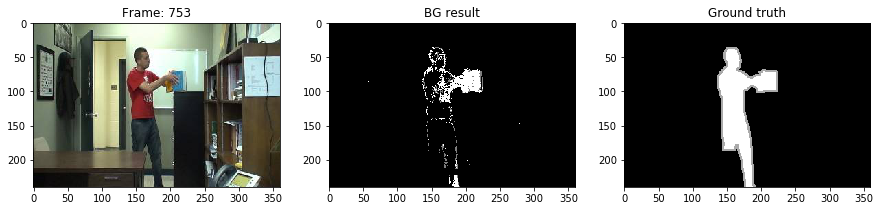

184it [01:19,  2.34it/s]

KeyboardInterrupt: 

In [39]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

In [63]:
DIR_PATH = os.path.expanduser("~/data/Images_2_data/HW_4_data/dataset/baseline/pedestrians/")

In [68]:
from cv2 import createBackgroundSubtractorMOG2

mog2 =  cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=20)
image_gen = image_generator(DIR_PATH, first_frame=550, last_frame=570)

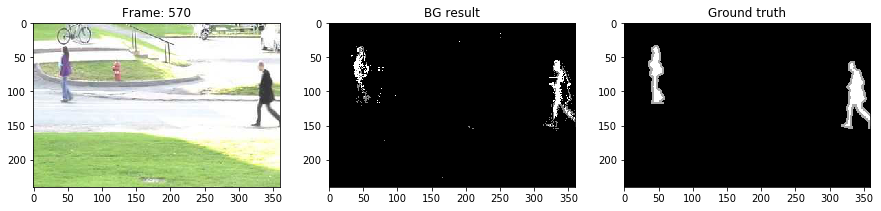

21it [00:08,  2.40it/s]


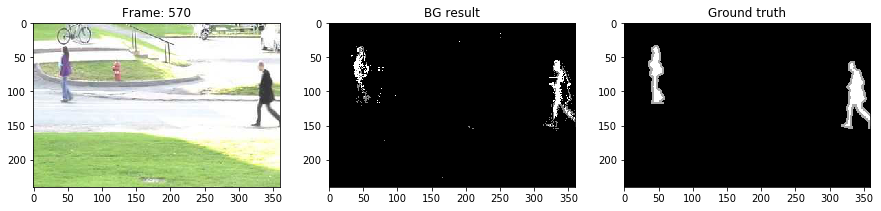

21it [00:08,  2.40it/s]


In [69]:
_, axs = plt.subplots(1, 3, figsize=(15, 5))

for numb, frame, mask, gt in tqdm(apply_bg_substractor(mog2, image_gen)):
    for ax in axs:
        ax.cla()
    plot_bg_result(numb, frame, mask, gt, axs)
    display.clear_output(wait=True)
    display.display(plt.gcf())
plt.close()

**Выводы:**

...

MOG2 очень быстро теряет почти неподвижные объекты, это видно на видео вверху, где человек почти целиком слился с фоном. Так же, MOG2 переодически выбрасывает целые куски картинки, а не отдеьные пиксели, в отличии от Vibe. Сами объекты переоцениваются на каждом шаге, поэтому они гораздо более "нечеткие", а их границы меняются от кадра к кадру.
Плюс MOG2 заключается в том, что если на начальном кадре есть объекты, он быстро на них реагирует и не возникеат "приведений", как в случае с Vibe. Но и в Vibe это можно исправить, увечилива частоту обновления.
В целом, я бы выбрал Vibe - визуальный результат у него приятный, нет дрожания, сам метод ну очень простой.

**7. (1 балл)**

Выберите один кадр из набора ключевых кадров, отобранных ключевых кадрах в пункте 3 и добавляйте к
нему попиксельно независимый гауссовский шум. Проанализируйте результаты вычитания фона обоими методами для шума различной интенсивности. Подберите параметры алгоритмов для работы с зашумленными изображениями.  Визуализируйте результаты работы обоих алгоритмов а также вычислите $f_1{\text -}score$ для всех экспрериментов. Сделайте выводы.

*Замечание 1:*  
Сравнение проводите честно, подавайте в алгоритм одинаковое кол-во впереди идущих кадров, необходимых для настройки внутренних параметров алгоритма.

*Замечание 2:*  
Ко всем кадрам, подаваемым в модель, необходимо также добавлять гауссовский шум.

In [27]:
DIR_PATH = os.path.expanduser("~/data/Images_2_data/HW_4_data/dataset/baseline/office/")

In [59]:
def get_mog2_result(sigma):
    """
    Apply MOG2 algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    image_gen = image_generator(DIR_PATH, first_frame=575, last_frame=600)
    bg_substractor =  cv2.createBackgroundSubtractorMOG2(history=100, varThreshold=50)
    for numb, frame, gt in image_gen:
        frame += np.random.normal(scale=sigma,size=frame.shape).astype('uint8')
        mask = bg_substractor.apply(frame)
    return frame, mask, gt
    

def get_vibe_result(sigma):
    """
    Apply ViBe algorithm for sequence of frames and return foreground mask for key frame

    :param sigma: Standard deviation of normal (Gaussian) distribution of noise
    :return: Foreground mask of key frame
    """
    image_gen = image_generator(DIR_PATH, first_frame=575, last_frame=600)
    # for noisy
    bg_substractor = Vibe(sample_amount=30, radius=50, K=2, subsampling_time=5)
    #bg_substractor = Vibe(sample_amount=30, radius=30, K=2, subsampling_time=5)
    for numb, frame, gt in image_gen:
        frame += np.random.normal(scale=sigma,size=frame.shape).astype('uint8')
        mask = bg_substractor.apply(frame)    
    return frame, mask, gt
    

In [60]:
def one_shot_metric(mask, gt):
    true_bg = np.logical_or(gt == 0, gt == 50)
    true_object = (gt == 255)  

    tn = (true_bg * (1 - mask)).sum()
    fp = (true_bg * mask).sum()
    fn = (true_object * (1 - mask)).sum()
    tp = (true_object * mask).sum()

    return np.array([tn, fp, fn, tp])

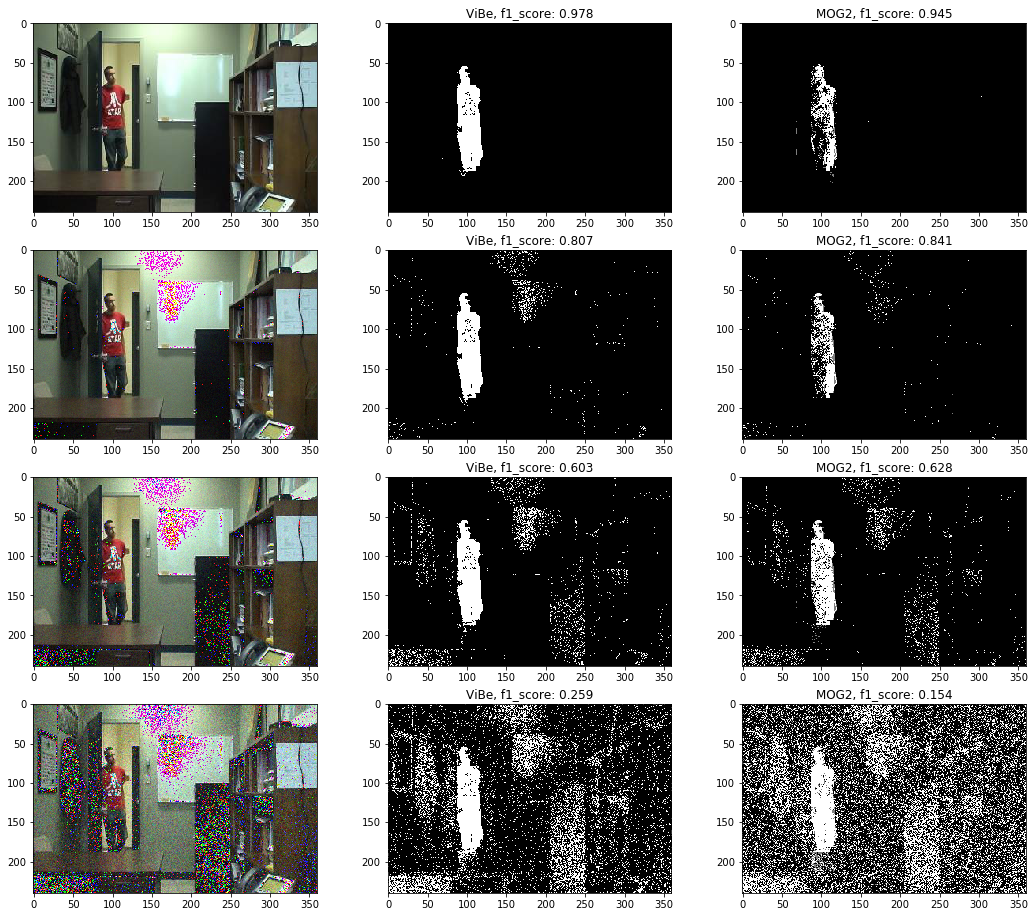

In [61]:
sigmas = [0, 5, 10, 20]
#sigmas = [0]

_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    frame, mog2_mask, gt = get_mog2_result(sigma)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("ViBe, f1_score: {:.3f}".format(f1_score(one_shot_metric(vibe_mask, gt))))
    
    axs[i][2].imshow(mog2_mask, cmap='gray')
    axs[i][2].set_title("MOG2, f1_score: {:.3f}".format(f1_score(one_shot_metric(mog2_mask, gt))))
plt.show()

**Выводы:**

...

У меня получилось настроить Vibe довольно  хорошо, так, что он стал работать лучше или сравнимо с MOG2. Возможно, я не попал в правильные паратмеры у MOG2, но Vibe неплохо удаляет шум. Я добился этого, за счет увеличения раидуса поиска соседей, что имеем смысл, так как при добавлении шума, расстояние между пикселясми фона увеличивается.

**8. (1 балл)**

Предложите метод борьбы с шумом на карте "фон-объект" и проанализируйте его эффективность. Сравнивайте результаты по какой-нибудь метрики качества, например $f_1{\text -}score$.

*Замечание:*

Можно использовать любые функции обработки изображений из библиотек `opencv` и `skimage`.

In [62]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)

In [94]:
denoise_wavelet?

In [97]:
def postprocess(mask):
    """
    Postprocessing foreground mask
    """
    sigma = estimate_sigma(mask, average_sigmas=False, multichannel=False)
    denoised_image = denoise_bilateral(mask, multichannel=False)
    # denoised_image = denoise_wavelet(mask, multichannel=False)
    return (denoised_image / denoised_image.max()) > 0.5

/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


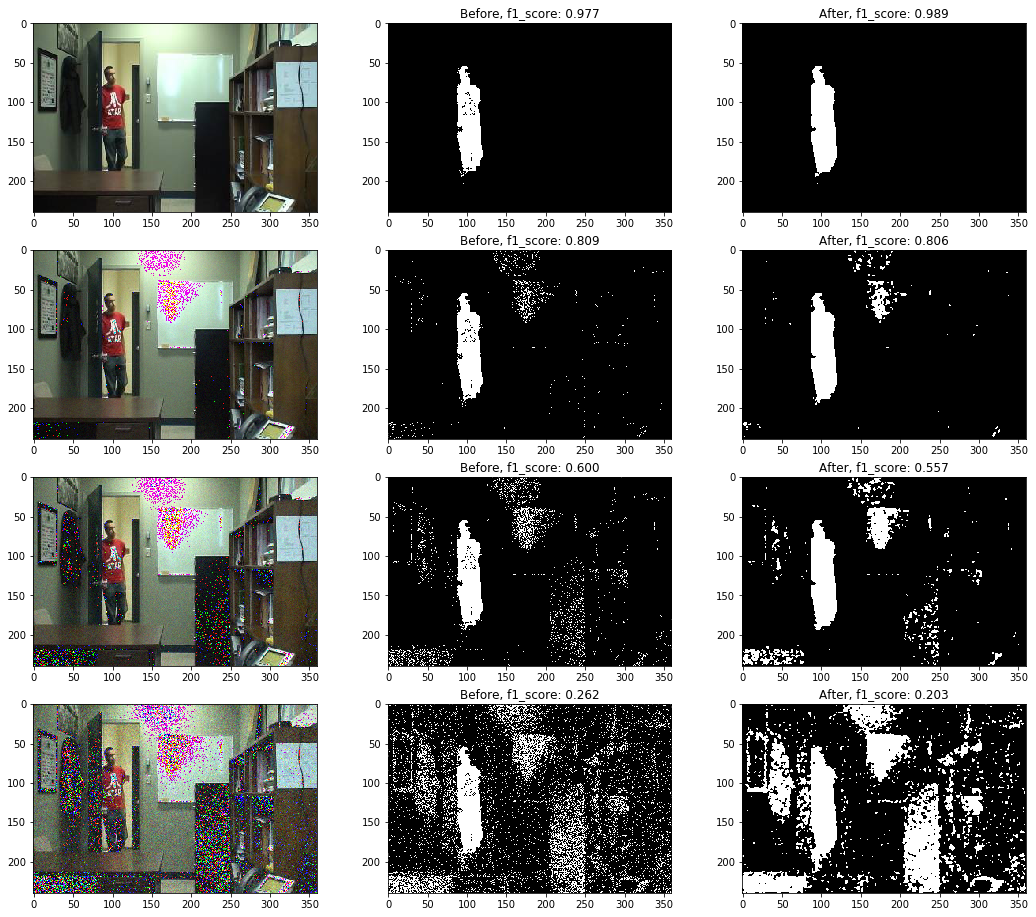

In [98]:
sigmas = [0, 5, 10, 20]
#sigmas = [0]


_, axs = plt.subplots(len(sigmas), 3, figsize=(18, len(sigmas) * 4), squeeze=False)

for i, sigma in enumerate(sigmas):
    frame, vibe_mask, gt = get_vibe_result(sigma)
    process_mask = postprocess(vibe_mask)
    axs[i][0].imshow(frame)
    
    axs[i][1].imshow(vibe_mask, cmap='gray')
    axs[i][1].set_title("Before, f1_score: {:.3f}".format(f1_score(one_shot_metric(vibe_mask, gt))))
    
    axs[i][2].imshow(process_mask, cmap='gray')
    axs[i][2].set_title("After, f1_score: {:.3f}".format(f1_score(one_shot_metric(process_mask, gt))))
plt.show()

**Выводы:**

...

Ну, убрать шум имеено на карте фон-объект у меня не получилось. Все что происходило- в лучшем случае денойзер убирал отдельные пиксели, зато скопления шумовых пикселей наоборот увеличивал, в итоге score только ухудшался. Либо ничего не менял в картинки. Думаю, в данном случае имело бы смысл сначала убрать шум с картинки, а потом подавать на вход алгоритму.